In [5]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from keras.models import Sequential
from keras.layers import Dense, Activation
from tensorflow.keras.layers import Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import keras

In [7]:
print(os.listdir("/gdrive/My Drive/DerinOgrenmeProje/lung_image_sets"))

['lung_squamous cell carcinoma', 'lung_adenocarcinoma', 'lung_benign tissue']


In [8]:
DATADIR = "/gdrive/My Drive/DerinOgrenmeProje/lung_image_sets"

CATEGORIES = ['lung_adenocarcinoma', 'lung_squamous cell carcinoma', 'lung_benign tissue']

IMG_SIZE = 100

In [9]:
all_data =[]

def create_all_data():
    for category in CATEGORIES:
        path=os.path.join(DATADIR, category)
        class_num=CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array=cv2.imread(os.path.join(path,img))
                new_array=cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
                all_data.append([new_array,class_num])
            except Exception as e:
                pass
create_all_data()

In [10]:
print("Toplam Görüntü Sayısı: ", len(all_data))

Toplam Görüntü Sayısı:  15000


In [11]:
X = []
y = []

for categories, label in all_data:
  X.append(categories)
  y.append(label)

In [12]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state =42)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.10, random_state=42)

In [13]:
x_train = np.array(x_train)
x_test = np.array(x_test)

y_train = np.array(y_train)
y_test = np.array(y_test)

x_val = np.array(x_val)
y_val = np.array(y_val)

In [14]:
print(x_train.shape)
print(x_test.shape)
print(x_val.shape)

print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(10800, 100, 100, 3)
(3000, 100, 100, 3)
(1200, 100, 100, 3)
(10800,)
(3000,)
(1200,)


In [15]:
train_yCl = tf.keras.utils.to_categorical(y_train, num_classes=3)
test_yCl = tf.keras.utils.to_categorical(y_test, num_classes=3)
valid_yCl = tf.keras.utils.to_categorical(y_val, num_classes=3)

In [16]:
model = Sequential()

# Giriş katmanı (Flatten ile görüntüleri vektöre çevirme)
model.add(Flatten(input_shape=(IMG_SIZE, IMG_SIZE, 3)))


model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))

model.add(BatchNormalization())

#Output Layer
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
callback_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='model.h5',
        monitor = 'val_accuracy', save_best_only=True, verbose=3
    ),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=3)
]

In [18]:
history = model.fit(x_train, train_yCl,
                    epochs=50,
                    validation_data=(x_val, valid_yCl),
                    callbacks = callback_list,
                    )

Epoch 1/50
338/338 [==============================] - ETA: 0s - loss: 0.6206 - accuracy: 0.6822
Epoch 1: val_accuracy improved from -inf to 0.65750, saving model to model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


338/338 [==============================] - 9s 8ms/step - loss: 0.6206 - accuracy: 0.6822 - val_loss: 0.6165 - val_accuracy: 0.6575
Epoch 2/50
333/338 [============================>.] - ETA: 0s - loss: 0.5054 - accuracy: 0.7397
Epoch 2: val_accuracy improved from 0.65750 to 0.69833, saving model to model.h5
338/338 [==============================] - 2s 7ms/step - loss: 0.5063 - accuracy: 0.7392 - val_loss: 0.5354 - val_accuracy: 0.6983
Epoch 3/50
335/338 [============================>.] - ETA: 0s - loss: 0.4975 - accuracy: 0.7535
Epoch 3: val_accuracy improved from 0.69833 to 0.76917, saving model to model.h5
338/338 [==============================] - 3s 8ms/step - loss: 0.4972 - accuracy: 0.7535 - val_loss: 0.5365 - val_accuracy: 0.7692
Epoch 4/50
333/338 [============================>.] - ETA: 0s - loss: 0.4802 - accuracy: 0.7579
Epoch 4: val_accuracy did not improve from 0.76917
338/338 [==============================] - 3s 9ms/step - loss: 0.4790 - accuracy: 0.7589 - val_loss: 0.565

In [19]:
res_model = keras.models.load_model('/content/model.h5')

In [20]:
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(test_yCl, axis=1)

accuracy = accuracy_score(y_test_classes, y_pred_classes)
precision = precision_score(y_test_classes, y_pred_classes, average="weighted")
recall = recall_score(y_test_classes, y_pred_classes, average="weighted")
f1_value = f1_score(y_test_classes, y_pred_classes, average="weighted")

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_value)

94/94 [==============================] - 0s 2ms/step
Accuracy: 0.778
Precision: 0.7832783819933518
Recall: 0.778
F1 Score: 0.7786526545705859


In [21]:
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[777 237  23]
 [356 614   0]
 [ 48   2 943]]


In [22]:
class_report = classification_report(y_test_classes, y_pred_classes)
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.75      0.70      1037
           1       0.72      0.63      0.67       970
           2       0.98      0.95      0.96       993

    accuracy                           0.78      3000
   macro avg       0.78      0.78      0.78      3000
weighted avg       0.78      0.78      0.78      3000



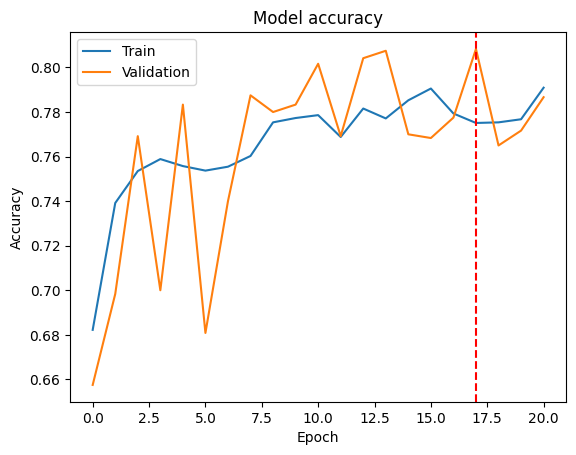

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')


# Early stopping durumunda çizgi ekleme
if 'val_accuracy' in history.history and 'val_loss' in history.history:
    best_epoch = np.argmax(history.history['val_accuracy'])
    plt.axvline(x=best_epoch, color='r', linestyle='--', label='Early Stopping Checkpoint')

plt.show()

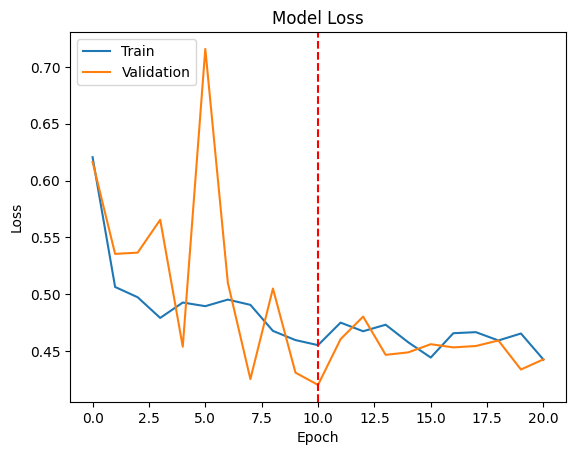

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Early stopping durumunda çizgi ekleme
if 'val_accuracy' in history.history and 'val_loss' in history.history:
    best_epoch = np.argmin(history.history['val_loss'])
    plt.axvline(x=best_epoch, color='r', linestyle='--', label='Early Stopping Checkpoint')

plt.show()

In [25]:
#model.h5'e göre Skorlar
y_pred = res_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(test_yCl, axis=1)

accuracy = accuracy_score(y_test_classes, y_pred_classes)
precision = precision_score(y_test_classes, y_pred_classes, average="weighted")
recall = recall_score(y_test_classes, y_pred_classes, average="weighted")
f1_value = f1_score(y_test_classes, y_pred_classes, average="weighted")

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_value)

94/94 [==============================] - 0s 2ms/step
Accuracy: 0.7916666666666666
Precision: 0.7952200208538525
Recall: 0.7916666666666666
F1 Score: 0.7930741295506651
